In [1]:
import poliastro as PA
import numpy as np
import matplotlib.pyplot as plt
import time as time_pkg

from astropy import units as u

from poliastro.bodies import Earth, Body
from poliastro.twobody import Orbit
from poliastro.examples import iss

from scipy.stats import expon, uniform, norm, triang
from scipy.special import comb

from lib.GPUKeplerSimulation import propagate, average_scaler, average_3vector
from lib.DisplaySimulation import displaySimulation

In [10]:
import cupy as cp

mempool = cp.get_default_memory_pool()

In [11]:
print(mempool.used_bytes())
mempool.free_all_blocks()
mempool.used_bytes()

1024


1024

In [ ]:
displaySimulation(orb)

In [ ]:
# Exponential Distribution
size = 100

J_1 = expon.rvs(scale=1, loc=0.0, size=size)

exponential_var2 = expon.rvs(scale=0.01, loc=0, size=size)
J_2 = J_1 - exponential_var2

for i in range(0,size):
    if J_2[i] < 0.0:
        J_2[i] = 0.0001

exponential_var3 = expon.rvs(scale=0.1, loc=0, size=size)
J_3 = J_2 - exponential_var3

for i in range(0,size):
    if J_3[i] < -J_2[i]:
        J_3[i] = -J_2[i]

M = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad
w = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad
Omega = uniform.rvs(loc = -np.pi, scale = np.pi, size=size) * u.rad

In [ ]:
# Near Circular Distribution
size = 500
r_0 = 1*u.km
sigma_e = 0.01*np.sqrt(1*u.km)
sigma_a = 0.000*np.sqrt(1*u.km)
alpha_over_m = 1*u.km**3/u.s**2 


expvar1 = expon.rvs(scale=sigma_e, loc=0, size=size)*np.sqrt(1*u.km)

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = expvar1 + J_2
J_3 = J_2

M = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [ ]:
# Near Gausian in R Distribution
size = 500
r_0 = 1*u.km
sigma_r = 0.5*u.kg*u.km**2
alpha_over_m = 1*u.km**3/u.s**2 


expvar1 = expon.rvs(scale=1, loc=0, size=size)

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = np.sqrt((np.power(J_2, 2) + np.sqrt(np.power(J_2, 4) + sigma_r*expvar1))/2.0)
J_3 = J_2

M = uniform.rvs(loc = -2*np.pi, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [2]:
# Near SHO Distribution
# Here I'm setting J_SHO = sqrt(ma^3/2k) * (p^2/2m + k/a^3*x^2)
# This leads to J_SHO = sqrt(ka/2)e^2 = sqrt(k/2)(J_1 - J_2^2/J_1)
# Then im distributing particles according to exp{- J_SHO/epsilon}

size = 20000
r_0 = 0.05*u.km
epsilon = 0.0000001*u.kg*u.km**2/u.s
k = 0.00112*u.kg*u.km**3/u.s**2 
m = 0.1*u.kg

J_SHO = expon.rvs(scale=epsilon, loc=0, size=size)*1*u.kg*u.km**2/u.s

#J_2 = expon.norm(scale=sigma_a, loc=r_0, size=size)
J_2 = np.repeat(np.sqrt(r_0), size)

J_1 = (J_SHO + np.sqrt(np.power(J_SHO, 2) + 4*k*m*np.power(J_2, 2)))/(2.0*np.sqrt(k*m))
J_3 = J_2

M = uniform.rvs(loc = -2*np.pi, scale = 2*np.pi, size=size) * u.rad
w = uniform.rvs(loc = 0, scale = 2*np.pi, size=size) * u.rad
Omega = np.repeat(0.0, size) * u.rad

In [3]:
omega = np.sqrt(k/m)/np.power(r_0, 3.0/2.0)
omega_prime = -3/(2*m*np.power(r_0, 2.0))
print("Omega_0: ", omega)
print("Omega_prime: ", omega_prime)
print("Decoherance Time: ", 2*np.pi/(omega_prime*epsilon))

# average_radius = 3*sigma_e**2 + 3*sigma_e*sigma_a + 3*sigma_e*np.sqrt(r_0) + 2*sigma_a**2 + 2*sigma_a*np.sqrt(r_0) + r_0
# print("Inital average radius: ", average_radius)

Omega_0:  9.465727652959384 1 / s
Omega_prime:  -5999.999999999998 1 / (kg km2)
Decoherance Time:  -10471.97551196598 s


In [4]:
a = np.square(J_1)
ecc = np.sqrt(1 - np.square(J_2/J_1)) * u.one
inc = np.arccos(J_3/J_2)

GM = Body(None, k/m, "Central Body")

In [5]:
class AsteriodBelt:
    size = 0
    micro = 1*u.km**3/u.s**2
    a = np.array([])*u.km
    ecc = np.array([])*u.one
    inc = np.array([])*u.rad
    Omega = np.array([])*u.rad
    w = np.array([])*u.rad
    M = np.array([])*u.rad
    def __init__(self, _size, _micro, _a, _ecc, _inc, _Omega, _w, _M):
        self.size = _size
        self.micro = _micro
        self.a = _a
        self.ecc = _ecc
        self.inc = _inc
        self.Omega = _Omega
        self.w = _w
        self.M = _M
        
    def setMeanAnamoly(self, _M):
        self.M = _M

In [6]:
belt = AsteriodBelt(size, k/m, a, ecc, inc, Omega, w, M)

In [7]:
timestep = 1*u.second

time_before_kick = 200*u.second
time_after_kick = 0*u.second
time_after_quad_kick = 0*u.second

dipole_time = time_before_kick
quad_time = time_before_kick + time_after_kick
end_time = time_before_kick + time_after_kick + time_after_quad_kick

dipole_step = int(dipole_time/timestep)
quad_step = int(quad_time/timestep)
end_step = int(end_time/timestep)


time = np.linspace(0.0*u.second, end_time, end_step)

avr_radius = np.zeros(end_step) * u.km

radiuses = np.zeros((size, end_step)) * u.km
velocities = np.zeros((size, end_step)) * u.km/u.s

In [8]:
gpuStart = time_pkg.time()
radiuses[:,0:dipole_step], velocities[:,0:dipole_step], final_mean_anamoly = propagate(belt, dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

MEM LIMIT:  6871947673
FIXED MEM:  480000   STEP MEMORY:  5280000
Max Steps:  1301.4143320075757   Frames:  2
GPU Memory in use before frames:  1024
Running propagation from  0  to  1301
<__main__.AsteriodBelt object at 0x0000025B559D0D30> [0.00000000e+00 1.00050025e-01 2.00100050e-01 ... 1.29864932e+02
 1.29964982e+02 1.30065033e+02] s 1301 None
 Obj Extract:  0.00598454475402832  E Calc:  0.6751935482025146
After clearing:  1024
Running propagation from  1301  to  2000
<__main__.AsteriodBelt object at 0x0000025B559D0D30> [130.16508254 130.26513257 130.36518259 130.46523262 130.56528264
 130.66533267 130.76538269 130.86543272 130.96548274 131.06553277
 131.16558279 131.26563282 131.36568284 131.46573287 131.56578289
 131.66583292 131.76588294 131.86593297 131.96598299 132.06603302
 132.16608304 132.26613307 132.36618309 132.46623312 132.56628314
 132.66633317 132.76638319 132.86643322 132.96648324 133.06653327
 133.16658329 133.26663332 133.36668334 133.46673337 133.56678339
 133.6668

In [9]:
avr_radius[0:dipole_step] = average_scaler(radiuses, end=dipole_step)

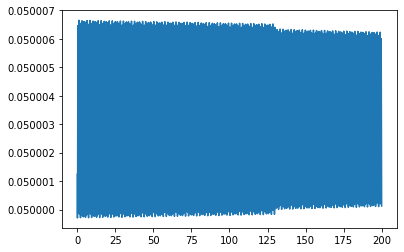

In [10]:
plt.plot(time[0:dipole_step], avr_radius[0:dipole_step])

In [ ]:
unit_r = np.empty(3) 
newR = np.empty(3)

orb = [None]*belt.size

for i in range(0, belt.size):
    orb[i] = Orbit.from_classical(GM, belt.a[i], belt.ecc[i], belt.inc[i], belt.Omega[i], belt.w[i], PA.core.angles.E_to_nu(PA.core.angles.E_to_M(belt.M[i], belt.ecc[i]), belt.ecc[i])*u.rad)

kickStrength = 0.001*u.km

for i in range(0, size):
        if orb[i].energy >= 0:
            print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
        old_radius = np.linalg.norm(orb[i].r)
        unit_r = orb[i].r/old_radius
        old_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
        newPosition = orb[i].r + kickStrength*unit_r
        oldThetaVelocity = orb[i].v - np.dot(orb[i].v, unit_r)*unit_r
        newThetaVelocity = old_radius/(old_radius + kickStrength)*oldThetaVelocity
        newVelocity = np.dot(orb[i].v, unit_r)*unit_r + newThetaVelocity
        orb[i] = Orbit.from_vectors(GM, newPosition, newVelocity)
        belt.a[i] = orb[i].a
        belt.ecc[i] = orb[i].ecc
        belt.inc[i] = orb[i].inc
        belt.Omega[i] = orb[i].raan
        belt.w[i] = orb[i].argp
        belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(orb[i].nu, orb[i].ecc), orb[i].ecc)*u.rad
        new_r_0 = orb[i].a*(1 - np.square(orb[i].ecc))
        if old_r_0 - new_r_0 > 10**-12*u.km:
            print("L_2 before and after do not match: ", old_r_0, "\t", new_r_0)
        if orb[i].energy >= 0:
            print(orb[i], " is not a bound orbit.")
        if (orb[i].r != newPosition).any():
            print("r got missassigned.")
#         if (np.linalg.norm(orb[i].r) > old_radius):
#             print("The new radius is greater than the original.", np.linalg.norm(orb[i].r), old_radius)
#             print(orb[i].r, old_radius)
#             print("Radius should be",np.linalg.norm(newPosition) )

In [ ]:
gpuStart = time_pkg.time()
radiuses[:,dipole_step:quad_step], velocities[:,dipole_step:quad_step], final_mean_anamoly = propagate(belt, quad_time-dipole_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

In [ ]:
avr_radius[dipole_step:quad_step] = average_scaler(radiuses, start=dipole_step, end=quad_step)

In [ ]:
plt.plot(time[0:quad_step], avr_radius[0:quad_step])

In [ ]:
unit_r = np.empty(3) 
newR = np.empty(3)

for i in range(0, belt.size):
    orb[i] = Orbit.from_classical(GM, belt.a[i], belt.ecc[i], belt.inc[i], belt.Omega[i], belt.w[i], PA.core.angles.E_to_nu(PA.core.angles.E_to_M(belt.M[i], belt.ecc[i]), belt.ecc[i])*u.rad)

quad_strength = 0.35 * u.second**-1
radius_offset = r_0

for i in range(0, size):
        if orb[i].energy >= 0:
            print(orb[i], " is ALREADY not a bound orbit BEFORE KICKING.")
        old_radius = np.linalg.norm(orb[i].r)
        unit_r = orb[i].r/old_radius
        newVelocity = orb[i].v + quad_strength*(old_radius - radius_offset)*unit_r
        orb[i] = Orbit.from_vectors(GM, orb[i].r, newVelocity)
        belt.a[i] = orb[i].a
        belt.ecc[i] = orb[i].ecc
        belt.inc[i] = orb[i].inc
        belt.Omega[i] = orb[i].raan
        belt.w[i] = orb[i].argp
        belt.M[i] = PA.core.angles.E_to_M(PA.core.angles.nu_to_E(orb[i].nu, orb[i].ecc), orb[i].ecc)*u.rad
        if orb[i].energy >= 0:
            print(orb[i], " is not a bound orbit.")
#         if (np.linalg.norm(orb[i].r) > old_radius):
#             print("The new radius is greater than the original.", np.linalg.norm(orb[i].r), old_radius)
#             print(orb[i].r, old_radius)
#             print("Radius should be",np.linalg.norm(newPosition) )

In [ ]:
gpuStart = time_pkg.time()
radiuses[:,quad_step:end_step], velocities[:,quad_step:end_step], final_mean_anamoly = propagate(belt, end_time - quad_time, timestep)
gpuEnd = time_pkg.time()
belt.setMeanAnamoly(final_mean_anamoly)
astroEnd = time_pkg.time()

print("GPU Time: ", gpuEnd-gpuStart, " Astro Time: ", astroEnd-gpuEnd)

In [ ]:
avr_radius[quad_step:end_step] = average_scaler(radiuses, start=quad_step, end=end_step)

In [ ]:
plt.plot(time[0:end_step], avr_radius[0:end_step])